In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

INFILE = '../data/adoption.csv'

In [2]:
df = pd.read_csv(INFILE)
df.head()

,WorkerId,Explanation,Adopt,WTP,OtherBid,WonAuction,SurveyCode,ID,EndTime,StartTime,...,married,output,y,FcastTimer,MostImportantFeature,Berlin2aTime,Berlin2a,Berlin3Time,Berlin3,next
0,test,0.0,1.0,0.75,0.0,1.0,q8gTgr,1,2020-11-28 14:34:26.675514,2020-11-28 14:21:48.145937,...,0.0,0.583456,0.0,23.719714,priors_count,NaN,NaN,NaN,NaN,NaN
1,test,0.0,1.0,0.75,0.0,1.0,q8gTgr,1,2020-11-28 14:34:26.675514,2020-11-28 14:21:48.145937,...,0.0,0.929194,1.0,15.386664,priors_count,NaN,NaN,NaN,NaN,NaN
2,test,0.0,1.0,0.75,0.0,1.0,q8gTgr,1,2020-11-28 14:34:26.675514,2020-11-28 14:21:48.145937,...,0.0,0.671215,1.0,21.148548,age,NaN,NaN,NaN,NaN,NaN
3,test,0.0,1.0,0.75,0.0,1.0,q8gTgr,1,2020-11-28 14:34:26.675514,2020-11-28 14:21:48.145937,...,0.0,0.763803,0.0,20.864336,age,NaN,NaN,NaN,NaN,NaN
4,test,0.0,1.0,0.75,0.0,1.0,q8gTgr,1,2020-11-28 14:34:26.675514,2020-11-28 14:21:48.145937,...,0.0,0.393829,0.0,15.924950,age,NaN,NaN,NaN,NaN,NaN


In [3]:
# select participants who passed comprehension checks
df = df[(df.WorkerId!='test')]
print('N total participants', len(pd.unique(df.ID)))
# remove participants who failed comprehension checks
df = df[(df.FcastComprehension==1) & (df.BonusComprehension==1)]
print('N passed comprehension check', len(pd.unique(df.ID)))
# remove participants who bid more than $10 (the high bid for the no-adoption condition)
# df = df[df.WTP <= 29.99]
print('N auction results matched adoption condition', len(pd.unique(df.ID)))
# select 'actual' forecasts (as opposed to practice forecasts)
df = df[df.Practice==0]
# scale forecasts to be between 0 and 1 (as opposed to 0 and 100)
df['Fcast'] = df['Fcast'] / 100.
# compute score and interaction variable
df['Exp_x_Adopt'] = df.Explanation * df.Adopt
df['Exp_x_black'] = df.Explanation * df.black
df['Adopt_x_black'] = df.Adopt * df.black
df['Score'] = (df.y - df.Fcast)**2 - (df.y - df.output)**2
df.values.shape

N total participants 647
N passed comprehension check 328
N auction results matched adoption condition 328


(3280, 83)

(array([   9.,   42.,  132.,  382., 1393.,  397.,  195.,  118.,   45.,
          17.]),
 array([-0.78596718, -0.6099641 , -0.43396102, -0.25795794, -0.08195486,
         0.09404822,  0.27005131,  0.44605439,  0.62205747,  0.79806055,
         0.97406363]),
 <BarContainer object of 10 artists>)

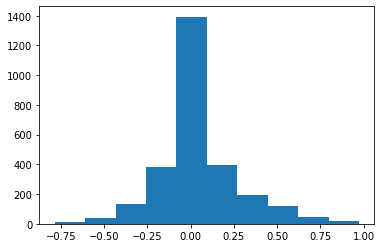

In [4]:
import matplotlib.pyplot as plt

plt.hist(df.Score)

In [5]:
# remove empty values from the score column
df = df.dropna(subset=['Score'])
df.values.shape

(2730, 83)

In [6]:
print("median WTP is", df.WTP.median())
df.groupby('Explanation').WTP.describe()

median WTP is 0.5


,count,mean,std,min,25%,50%,75%,max
Explanation,,,,,,,,
0.0,1380.0,2.152246,5.412665,0.0,0.2,0.5,1.0,30.0
1.0,1350.0,4.278815,8.072855,0.0,0.2,0.5,1.5,30.0


In [7]:
tmp_df = df.drop_duplicates(['ID'])
tmp_df['WTP'] = tmp_df.WTP.clip(0, 10)
X = sm.add_constant(tmp_df.Explanation)
reg = sm.OLS(tmp_df.WTP, X)
res = reg.fit().get_robustcov_results(cov_type='HC0')
res.summary()

/home/dsbowen/algorithm-fairness/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    WTP   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     6.092
Date:                Wed, 02 Dec 2020   Prob (F-statistic):             0.0142
Time:                        11:22:14   Log-Likelihood:                -714.34
No. Observations:                 273   AIC:                             1433.
Df Residuals:                     271   BIC:                             1440.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.4856      0.232      6.417      0.000       1.030       1.941
Explanation     0.9932      0.402      2.468      0.014       0.201       1.786
==============================================================================
Omnibus:                       89.166   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.243
Skew:                           1.792   Prob(JB):                     1.46e-38
Kurtosis:                       4.571   Cond. No.                         2.61
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

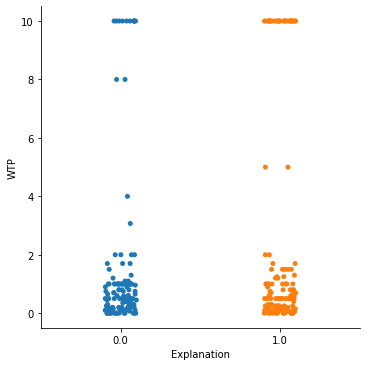

In [8]:
import seaborn as sns

sns.catplot(x='Explanation', y='WTP', data=tmp_df)

In [9]:
# effect of explanation on performance if everyone adopted the model
# negative coef on interaction indicates the explanation improved performance
# positive coef on interaction indicates the explanation harmed performance
adopt_df = df[df.Adopt==1]
X = sm.add_constant(adopt_df.Explanation)
reg = sm.OLS(adopt_df.Score, X)
res = reg.fit().get_robustcov_results(cov_type='cluster', groups=adopt_df.ID)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.07361
Date:                Wed, 02 Dec 2020   Prob (F-statistic):              0.787
Time:                        11:22:15   Log-Likelihood:                 311.91
No. Observations:                1510   AIC:                            -619.8
Df Residuals:                    1508   BIC:                            -609.2
Df Model:                           1                                         
Covariance Type:              cluster                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0305      0.009      3.282      0.001       0.012       0.049
Explanation    -0.0032      0.012     -0.271      0.787      -0.027       0.020
==============================================================================
Omnibus:                      308.505   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1071.207
Skew:                           0.980   Prob(JB):                    2.46e-233
Kurtosis:                       6.631   Cond. No.                         2.66
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [10]:
# effect of explanation on fairness if everyone adopted the model
# negative coef on interaction indicates the explanation improved fairness
# positive coef on interaction indicates the explanation harmed fairness

# select observations where the offender did not recidivate and the model was adopted
no_recid_df = adopt_df[adopt_df.y == 0]
X = sm.add_constant(no_recid_df[['Explanation', 'black', 'Exp_x_black']])
reg = sm.OLS(no_recid_df.Score, X)
res = reg.fit().get_robustcov_results(cov_type='cluster', groups=no_recid_df.ID)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     3.636
Date:                Wed, 02 Dec 2020   Prob (F-statistic):             0.0143
Time:                        11:22:15   Log-Likelihood:                 170.45
No. Observations:                 740   AIC:                            -332.9
Df Residuals:                     736   BIC:                            -314.5
Df Model:                           3                                         
Covariance Type:              cluster                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0143      0.020      0.726      0.469      -0.025       0.053
Explanation  2.231e-05      0.027      0.001      0.999      -0.052       0.053
black           0.0521      0.023      2.278      0.024       0.007       0.097
Exp_x_black    -0.0048      0.030     -0.156      0.876      -0.065       0.055
==============================================================================
Omnibus:                       91.263   Durbin-Watson:                   1.588
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              204.832
Skew:                           0.693   Prob(JB):                     3.32e-45
Kurtosis:                       5.173   Cond. No.                         7.09
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [11]:
def simulate_market(df, price):
    # indicates the participant would have adopted the model in this simulation
    df = df[df.Adopt == (df.WTP > price)]
    compute_performance_effect(df, price)
    compute_fairness_effect(df, price)
    compute_adoption_effect(df, price)
    decompose(df, price)
    
def compute_performance_effect(df, price):
    X = sm.add_constant(df.Explanation)
    reg = sm.OLS(df.Score, X)
    res = reg.fit().get_robustcov_results(cov_type='cluster', groups=df.ID)
    print('\nNegative coefficient on explanation indicates that explanation improved performance')
    print('Positive coefficient on explanation indicates that explanation harmed performance\n')
    print(res.summary())
    
def compute_fairness_effect(df, price):
    df = df[df.y == 0]
    df['Exp_x_black'] = df.Explanation * df.black
    X = sm.add_constant(df[['Explanation', 'black', 'Exp_x_black']])
    reg = sm.OLS(df.Score, X)
    res = reg.fit().get_robustcov_results(cov_type='cluster', groups=df.ID)
    print('\nNegative coefficient on interaction indicates that explanation improved fairness')
    print('Positive coefficient on interaction indicates that explanation harmed fairness\n')
    print(res.summary())
    
def compute_adoption_effect(df, price):
    df = df.drop_duplicates(subset=['ID'])
    X = sm.add_constant(df.Explanation)
    reg = sm.OLS(df.Adopt, X)
    res = reg.fit().get_robustcov_results(cov_type='HC0')
    print('\nPositive coefficient on explanation indicates the explanation increased adoption')
    print('Negative coefficient on explanation indicates that explanation decreased adoption\n')
    print(res.summary())
    
def decompose(df, price):
    X = sm.add_constant(df[['Explanation', 'Adopt', 'Exp_x_Adopt']])
    reg = sm.OLS(df.Score, X)
    res = reg.fit().get_robustcov_results(cov_type='cluster', groups=df.ID)
    print(res.summary())
    
price = df.drop_duplicates(subset='ID').WTP.median()
# price = df.WTP.quantile(.7)
simulate_market(df, price)


Negative coefficient on explanation indicates that explanation improved performance
Positive coefficient on explanation indicates that explanation harmed performance

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1967
Date:                Wed, 02 Dec 2020   Prob (F-statistic):              0.658
Time:                        11:22:15   Log-Likelihood:                 84.807
No. Observations:                1370   AIC:                            -165.6
Df Residuals:                    1368   BIC:                            -155.2
Df Model:                           1                                         
Covariance Type:              cluster                                         
                  coef    std err         

/home/dsbowen/algorithm-fairness/venv/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
df['Trust'] = (df.output - df.Fcast)**2
X = sm.add_constant(df[['Explanation', 'Adopt', 'Exp_x_Adopt']])
reg = sm.OLS(df.Trust, X)
res = reg.fit().get_robustcov_results(cov_type='cluster', groups=df.ID)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Trust   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     9.544
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           5.16e-06
Time:                        11:22:15   Log-Likelihood:                 2746.6
No. Observations:                2730   AIC:                            -5485.
Df Residuals:                    2726   BIC:                            -5462.
Df Model:                           3                                         
Covariance Type:              cluster                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0664      0.005     13.104      0.000       0.056       0.076
Explanation     0.0090      0.009      1.015      0.311      -0.008       0.026
Adopt          -0.0231      0.007     -3.137      0.002      -0.038      -0.009
Exp_x_Adopt    -0.0154      0.012     -1.316      0.189      -0.038       0.008
==============================================================================
Omnibus:                     1637.470   Durbin-Watson:                   1.591
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14114.259
Skew:                           2.804   Prob(JB):                         0.00
Kurtosis:                      12.624   Cond. No.                         7.19
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [13]:
X = sm.add_constant(df.Adopt)
reg = sm.OLS(df.Score, X)
res = reg.fit().get_robustcov_results(cov_type='cluster', groups=df.ID)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.153
Date:                Wed, 02 Dec 2020   Prob (F-statistic):            0.00794
Time:                        11:22:15   Log-Likelihood:                 160.84
No. Observations:                2730   AIC:                            -317.7
Df Residuals:                    2728   BIC:                            -305.8
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0548      0.008      7.099      0.000       0.040       0.070
Adopt         -0.0259      0.010     -2.674      0.008      -0.045      -0.007
==============================================================================
Omnibus:                      284.874   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              600.182
Skew:                           0.651   Prob(JB):                    4.70e-131
Kurtosis:                       4.892   Cond. No.                         2.76
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [14]:
no_recid_df = df[df.y==0]
X = sm.add_constant(no_recid_df[['Adopt', 'black', 'Adopt_x_black']])
reg = sm.OLS(no_recid_df.Score, X)
res = reg.fit().get_robustcov_results(cov_type='cluster', groups=no_recid_df.ID)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     6.649
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           0.000239
Time:                        11:22:15   Log-Likelihood:                 99.814
No. Observations:                1326   AIC:                            -191.6
Df Residuals:                    1322   BIC:                            -170.9
Df Model:                           3                                         
Covariance Type:              cluster                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0380      0.018      2.163      0.031       0.003       0.073
Adopt            -0.0237      0.022     -1.080      0.281      -0.067       0.020
black             0.0559      0.021      2.661      0.008       0.015       0.097
Adopt_x_black    -0.0061      0.026     -0.236      0.814      -0.057       0.045
==============================================================================
Omnibus:                       71.084   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.613
Skew:                           0.426   Prob(JB):                     7.85e-26
Kurtosis:                       4.169   Cond. No.                         7.35
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [15]:
df.groupby(['Explanation', 'y']).Fcast.mean()

Explanation  y  
0.0          0.0    0.454518
             1.0    0.583617
1.0          0.0    0.467160
             1.0    0.592573
Name: Fcast, dtype: float64

In [16]:
df.groupby(['Explanation', 'black', 'y']).Fcast.mean()

Explanation  black  y  
0.0          0.0    0.0    0.421258
                    1.0    0.559817
             1.0    0.0    0.483644
                    1.0    0.598284
1.0          0.0    0.0    0.432367
                    1.0    0.552542
             1.0    0.0    0.503457
                    1.0    0.614018
Name: Fcast, dtype: float64

In [17]:
df.groupby(['black', 'y']).output.mean()

black  y  
0.0    0.0    0.427821
       1.0    0.569132
1.0    0.0    0.437889
       1.0    0.606181
Name: output, dtype: float64

In [57]:
from hemlock.tools import get_approve_df, approve_assignments

data_df = pd.read_csv(INFILE)
data_df['Score'] = (data_df.y-data_df.Fcast/100.)**2 - (data_df.y-data_df.output)**2
# calculate bonus
data_df['BonusAmount'] = 15 * (1-data_df.groupby('WorkerId').Score.transform('mean'))
data_df = data_df.drop_duplicates('WorkerId')
data_df.BonusAmount.describe()

count    404.000000
mean      14.201057
std        1.170813
min        9.481965
25%       13.723498
50%       14.420224
75%       14.922825
max       17.179478
Name: BonusAmount, dtype: float64

In [58]:
# subtract the competing bid if the participant won the auction
data_df['BonusAmount'] = data_df.BonusAmount - data_df.OtherBid * data_df.WonAuction
# minimum bonus is $0
data_df['BonusAmount'] = data_df.BonusAmount.clip(0)
data_df.BonusAmount.describe()

count    395.000000
mean      13.952034
std        2.195625
min        0.000000
25%       13.678670
50%       14.386880
75%       14.906520
max       17.179478
Name: BonusAmount, dtype: float64

In [59]:
# select 1 in 10 workers to receive a bonus
data_df['BonusAmount'].iloc[data_df.ID % 10 != 0] = 0
data_df.BonusAmount.describe()

/home/dsbowen/algorithm-fairness/venv/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


count    469.000000
mean       1.197239
std        3.991565
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       16.209754
Name: BonusAmount, dtype: float64

In [60]:
batch_df = pd.read_csv('../data/adoption_10_batch.csv')
batch_df = batch_df.append(pd.read_csv('../data/adoption_390_batch.csv'))
approve_df = get_approve_df(data_df, batch_df, bonus=True)
# assume rejected assignments were honest mistakes entering the completion code
approve_df['Approve'] = True

383 assignments approved
16 assignments rejected
Total bonus: $561.51


In [22]:
import boto3

client = boto3.client(
    'mturk',
    region_name='us-east-1',
    aws_access_key_id='KEY',
    aws_secret_access_key='SECRET_KEY'
)
# approve_assignments(client, approve_df, bonus=True, bonus_reason='For accurate predictions in my recidivism study')